In [15]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow
# yfinance → to download stock data directly from Yahoo Finance
# pandas → to handle and manipulate data (tables)
# numpy → for numerical operations
# matplotlib → for plotting graphs
# scikit-learn → for scaling and metrics
# tensorflow → to build and train the LSTM model

In [16]:
import yfinance as yf          # To get stock data
import pandas as pd            # To handle data
import numpy as np             # For array/matrix operations
import matplotlib.pyplot as plt # For plotting graphs
from sklearn.preprocessing import MinMaxScaler  # To scale numbers
from sklearn.metrics import mean_squared_error   # To measure accuracy
from tensorflow.keras.models import Sequential   # To create the model
from tensorflow.keras.layers import LSTM, Dense  # Layers for LSTM network
import math
# We import all tools we’ll use later — each has a specific job (data handling, visualization, modeling).

In [17]:
# Download Apple's stock data from Yahoo Finance
df = yf.download('AAPL', start='2015-01-01', end='2025-01-01')

# Display the first 5 rows
print(df.head())

# yf.download() downloads the stock price data for the given symbol (AAPL = Apple).
# We get Open, High, Low, Close, Adj Close, and Volume.
# We print the first few rows to check our data.

C:\Users\User\AppData\Local\Temp\ipykernel_1296\2355182751.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261042  24.729265  23.821666  24.718169  212818400
2015-01-05  23.577574  24.110150  23.391173  24.030263  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910433  24.010290  23.677430  23.788384  160423600
2015-01-08  24.829126  24.886823  24.121244  24.238856  237458000


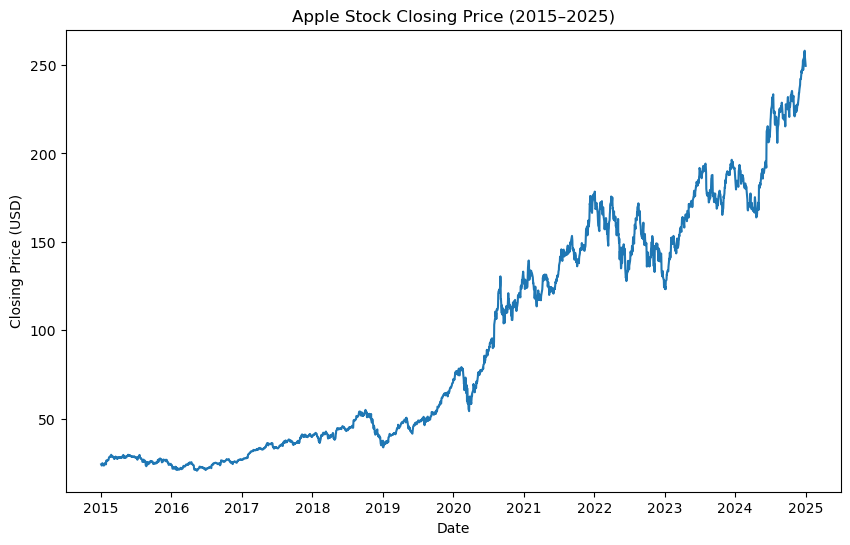

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df['Close'])
plt.title("Apple Stock Closing Price (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.show()

# We plot the ‘Close’ column to see how Apple’s stock price has changed over time.
# Helps us visualize the trend (increasing, decreasing, or fluctuating).

In [19]:
# Use only the 'Close' price column for prediction
data = df[['Close']].values

# Scale data between 0 and 1 (helps neural networks learn faster)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# We only care about the closing price.
# LSTMs work better when data is normalized between 0 and 1, so we scale it.

In [20]:
time_steps = 60  # How many days we’ll look back
X = []
y = []

# Loop through the data
for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data[i-time_steps:i, 0])  # last 60 days
    y.append(scaled_data[i, 0])               # next day's price

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Each training sample uses past 60 days (time_steps) to predict the next day.
# X = input features (previous 60 days)
# y = output (next day price)
# We store them as NumPy arrays for training.

In [21]:
# LSTM needs 3D input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Our data currently has shape (samples, time_steps) → 2D.
# LSTM expects (samples, time_steps, features) → 3D.
# Since we only have 1 feature (Close price), we reshape it.

In [22]:
# Use 80% data for training, 20% for testing
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# We don’t shuffle the data — stock prices are time-ordered.
# Model learns from past data and tests on future unseen data.
# Training = older data, Testing = latest data.

In [23]:
model = Sequential()

# First LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Second LSTM layer
model.add(LSTM(50, return_sequences=False))

# Fully connected (Dense) layer
model.add(Dense(25))

# Output layer (1 neuron for next day's price)
model.add(Dense(1))

# Compile model (define optimizer and loss function)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

# Sequential: simple stack of layers.
# LSTM layers: learn patterns from sequences of prices.
# Dense layers: map features to the final output.
# Adam optimizer: adjusts learning automatically.
# Loss function (MSE): measures how far off predictions are.

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model for 10 passes through the data
model.fit(X_train, y_train, batch_size=32, epochs=10)

# batch_size=32 → model learns from 32 samples at a time.
# epochs=10 → number of times the model sees the entire dataset.
# More epochs = more learning (but longer training time).

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0053
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.7306e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.7893e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.3148e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3483e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4746e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4597e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2599e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9642e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8743e-04


In [11]:
# Predict on test data
predictions = model.predict(X_test)

# Convert scaled predictions back to actual prices
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Model outputs scaled values (0–1), so we convert them back to real USD prices using inverse_transform().
# Now we can compare real prices with predicted ones.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 


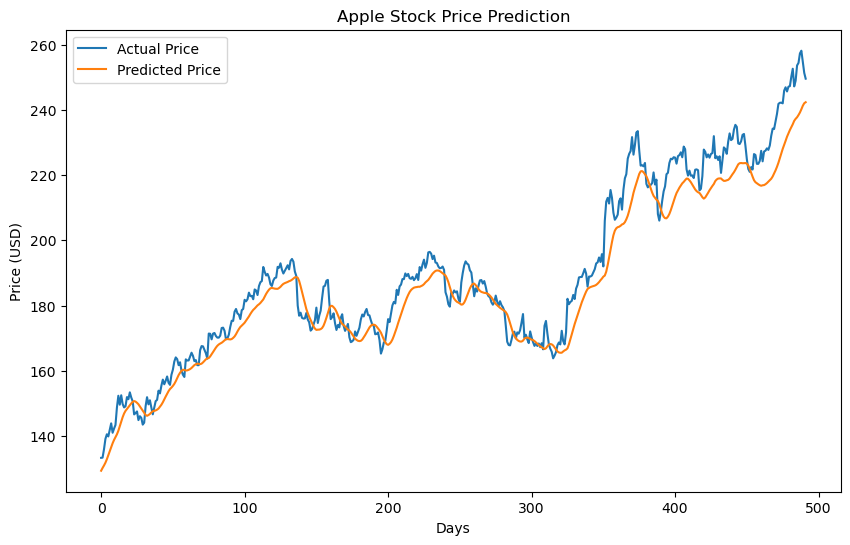

In [25]:
plt.figure(figsize=(10,6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.title("Apple Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# The blue line = real stock price.
# The orange line = model’s prediction.
# The closer they are → the better the model learned the pattern.

In [26]:
rmse = math.sqrt(mean_squared_error(actual_prices, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

# RMSE tells how far predictions are from actual prices (in USD).
# Smaller RMSE = better model performance.

Root Mean Squared Error (RMSE): 7.33825090158865


In [29]:
# Take last 60 days of data
last_60_days = scaled_data[-60:]

# Prepare input for model
X_next = np.array([last_60_days])
X_next = np.reshape(X_next, (X_next.shape[0], X_next.shape[1], 1))

# Predict next day's closing price
next_day_scaled = model.predict(X_next)
next_day_price = scaler.inverse_transform(next_day_scaled)

print("Predicted Next Day Closing Price (USD):", next_day_price[0][0])

# We take the most recent 60 days and feed it to our trained model.
# It predicts what the next day’s closing price might be.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Next Day Closing Price (USD): 237.55476
